Knn :
Mean accuracy: 0.9648182957393482 
Standard diviation: 0.03143716992637167

SVC :
Mean accuracy: 0.9719298245614034 
Standard diviation: 0.02505764360892229

pvalue:  0.3967708732699985
the differrence in accuracy between classifiers Knn and SVC is not significant
Knn mean AUC:  0.9859489452346597
SVC mean AUC:  0.9953676217961933


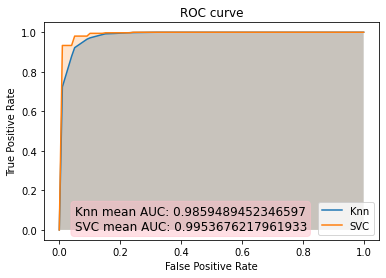

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, scale

import matplotlib.pyplot as plt

data, target = load_breast_cancer(True)
data = scale(data)

n_neighbors = [1, 3, 5, 7]
C = [0.01, 0.1, 1, 10]

Knn_param_grid = dict(n_neighbors=n_neighbors)
SVC_param_grid = dict(kernel=["linear"], C=C)


Knn = KNeighborsClassifier()
SVC = SVC(probability=True) 

#inner cross-validation for hyper parameter tuning
Knn_clf = GridSearchCV(Knn, Knn_param_grid, cv=5) 
SVC_clf = GridSearchCV(SVC, SVC_param_grid, cv=5)

#outer cross-falidation for estimating the accuracy of the classifier
Kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2)

Knn_acc_list = cross_val_score(Knn_clf, data, target, scoring = 'accuracy', cv=Kfold)
SVC_acc_list = cross_val_score(SVC_clf, data, target, scoring = 'accuracy', cv=Kfold)

print("Knn :\nMean accuracy:", np.mean(Knn_acc_list), "\nStandard diviation:", np.std(Knn_acc_list))
print("\nSVC :\nMean accuracy:", np.mean(SVC_acc_list), "\nStandard diviation:", np.std(SVC_acc_list))
t, pvalue = stats.ttest_rel(Knn_acc_list, SVC_acc_list)

print("\npvalue: ", pvalue)

if pvalue<=0.05:
    print('the differrence in accuracy between classifiers Knn and SVC is significant')
else:
    print('the differrence in accuracy between classifiers Knn and SVC is not significant')

# Knn ROC and AUC   
Knn_mean_fpr = np.linspace(0,1,100)
Knn_mean_tpr = 0
Knn_mean_auc = 0
Knn_pos_class_idx = 1

for train_index, test_index in Kfold.split(data, target):
    Knn.fit(data[train_index], target[train_index])
    Knn_score = Knn.predict_proba(data[test_index])[:,Knn_pos_class_idx]
    fpr,tpr, threshold = sklearn.metrics.roc_curve(target[test_index], Knn_score, pos_label =1)
    Knn_mean_tpr += np.interp(Knn_mean_fpr, fpr, tpr)
    Knn_mean_auc += sklearn.metrics.auc(fpr, tpr) 
    
Knn_mean_auc/=10
Knn_mean_tpr[0] = 0
Knn_mean_tpr/=10
Knn_mean_tpr[-1] = 1

print("Knn mean AUC: ",Knn_mean_auc)

#SVC ROC and AUC
SVC_mean_fpr = np.linspace(0,1,100)
SVC_mean_tpr = 0
SVC_mean_auc = 0
SVC_pos_class_idx = 1

for train_index, test_index in Kfold.split(data, target):
    SVC.fit(data[train_index], target[train_index])
    SVC_score = SVC.predict_proba(data[test_index])[:, SVC_pos_class_idx]
    fpr, tpr, threshold = sklearn.metrics.roc_curve(target[test_index], SVC_score, pos_label =1)
    SVC_mean_tpr += np.interp(SVC_mean_fpr, fpr, tpr)
    SVC_mean_auc += sklearn.metrics.auc(fpr, tpr)

SVC_mean_auc/=10
SVC_mean_tpr[0] = 0
SVC_mean_tpr/=10
SVC_mean_tpr[-1] = 1
print("SVC mean AUC: ",SVC_mean_auc)

#Plot
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

props = dict(boxstyle='round', color="pink", alpha=0.5)
plt.text(0.05,0, "Knn mean AUC: "+ str(Knn_mean_auc) + "\nSVC mean AUC: "+ str(SVC_mean_auc),
         fontsize = 12, bbox=props)

plt.plot(Knn_mean_fpr, Knn_mean_tpr, label="Knn")
plt.fill_between(Knn_mean_fpr, 0, Knn_mean_tpr, alpha=0.3)

plt.plot(SVC_mean_fpr, SVC_mean_tpr, label="SVC")
plt.fill_between(SVC_mean_fpr, 0, SVC_mean_tpr, alpha=0.2)

plt.legend()
plt.show()